## SIMULAÇÃO LINHA ATUAL 

IMPORTS

In [98]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches

### ETAPA 1 - OBTENDO INFORMAÇÕES YAMAZUMI

In [99]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 2: OBTENDO DADOS SEQUENCIA DO DIA

In [ ]:
sequencia = pd.read_csv("sequencia_producao.csv", sep=';')

# Extrai os 7 primeiros caracteres da coluna 'Baumuster'
sequencia['Baumuster_7dig'] = sequencia['Baumuster'].astype(str).str[:7]
sequencia_modelos = sequencia["Baumuster_7dig"].tolist()
print(sequencia_modelos)

# isso terá que estar dentro do loop 
# filter por data 1 planilha para aquela data 
# ler excel 

['C951501', 'C951501', 'C968403', 'C968450', 'C951102', 'C963425', 'C951501', 'C968114', 'C951501', 'C951104', 'C951501', 'C963425', 'C951501', 'C968114', 'C951104', 'C963414', 'C963425', 'C963411', 'C963414', 'C951104', 'C968403', 'C951102', 'C963425', 'C951501', 'C951102', 'C951501', 'C968403', 'C963425', 'C951104', 'C951544', 'C951501', 'C963414', 'C951501', 'C951501', 'C951501', 'C963411', 'C951511', 'C951104', 'C951501', 'C963425', 'C951501', 'C951511', 'C951104', 'C963425', 'C951501', 'C968403', 'C951501', 'C963425', 'C951104', 'C968403', 'C951501', 'C963425', 'C951104', 'C951104', 'C963425', 'C951501', 'C951514', 'C963414', 'C951104', 'C951544', 'C951501', 'C951544', 'C951511', 'C963425', 'C951514', 'C951511', 'C963411', 'C951501', 'C968403', 'C951104', 'C963425', 'C951102', 'C951500', 'C951511', 'C963414', 'C951104', 'C951511', 'C951104', 'C963425', 'C951511', 'C951501', 'C964016', 'C951511', 'C951102', 'C968450', 'C951501', 'C963425', 'C951501', 'C968114', 'C951104', 'C951104'

### ETAPA 3: PREPARANDO DICIONÁRIO POR POSTO

### Configuração perna 1: 
19 operadores no total sendo 1 por atividade, com excessões: 
- DIESEL - 30A  
- ARREFEC - 31A  
- REAPERTO - 32A  
- 5AA_RODA - 32C (só ATP)  
- ESTEPE - 32C  
- PNEU_LE + PNEU_LD - 33A (2 operadores)  
- APERTO_LE + APERTO_LD - 34A (2 operadores)  
- GRADE- 34A  
- MECACNICA_1 + MECACNICA_2 - Início: 34A; Fim: 38 (2 operadores)  
- ELECTRICA_1 + ELECTRICA_2 - Início: 32A; Fim: 33A (2 operadores)  
- CONTROLE - 34A  
- MOTORISTA - 38  
- QUIS - 38  




### Configuração perna 2:
13 operadores no total sendo 1 por atividade, com excessões: 
- PASSADISASSO - 30B 
- ABASTECIMENTO - 31B   
- CHINELEIRA - 32B  
- 5AA_RODA - 32D  
- PNEU_LE + PNEU_LD - 33B (2 operadores)  
- PARALAMA_LD + PARALAMA_LE - 34B (1 op)  
Paralama e pneu é feito ao mesmo tempo, assim, tempo paralama conta como 1
- CONTROLE - 34B 
- ELACTRICA_I + ELACTRICA_II + ELACTRICA_III - Início: 33B; Fim: 39 (3 operadores)  
Na elétrica, podemos considerar como se 1 operador fizesse 1 atvidade total distribuída pelos 3 postos  


In [101]:

# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              }

ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':0.5},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':0.5},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}
              }


In [102]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    POSTOS = {}

    GRUPOS_ESPECIAIS = {
        'P1': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
            'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
            'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"}
        },
        'P2': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "media"},
            'ELETRICA': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II', 'ELACTRICA_III'], "agreg": "media"}
        }
    }

    for modelo, dados_modelo in MODELOS_CSV.items():
        perna = dados_modelo["perna"]
        arquivo = dados_modelo["tempos"]
        tempos_atividade = get_process_times_from_csv(arquivo)
        
        print(tempos_atividade)
        
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2
        grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

        dicionario_postos = {}

        # Aplica regras especiais por grupo
        for nome_grupo, grupo in grupos.items():
            atividades = grupo["atividades"]

            if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
                continue  # ignora se alguma atividade do grupo não existe

            if grupo["agreg"] == "media":
                tempo_total = sum(tempos_atividade[a] / atividades_dict[a]['operadores'] for a in atividades)
                tempo = tempo_total / len(atividades)
            elif grupo["agreg"] == "soma_oper":
                tempo_total = sum(tempos_atividade[a] for a in atividades)
                total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades)
                tempo = tempo_total / total_operadores
            else:
                continue

            # aplica tempo dividido entre os postos das atividades
            postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
            for posto in postos_grupo:
                dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
                dicionario_postos[posto]["tempo_tot"] += tempo / len(postos_grupo)

        # adiciona atividades individuais
        for atividade, props in atividades_dict.items():
            if modelo not in props['modelos']:
                continue
            if atividade not in tempos_atividade:
                continue

            tempo = tempos_atividade[atividade] / props['operadores']
            for posto in props['postos']:
                dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
                dicionario_postos[posto]["tempo_tot"] += tempo

        # ordena os postos
        postos_ordenados = {}
        for posto in ordem_postos:
            if posto in dicionario_postos:
                postos_ordenados[posto] = dicionario_postos[posto]

        POSTOS[modelo] = postos_ordenados

    return POSTOS


In [103]:
POSTOS = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
print("\n--- Tempos por posto por modelo ---")
for modelo, valor in POSTOS.items():
    print(f"{modelo}: {valor}")

{'ARREFEC': 316, 'DIESEL': 253, 'REAPERTO': 235, 'ESTEPE': 290, 'PNEU_LD': 250, 'PNEU_LE': 250, 'APERTO_LD': 304, 'APERTO_LE': 304, 'GRADE': 270, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 357, 'ELACTRICA_2': 357, 'CONTROLE': 265, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 314, 'DIESEL': 314, 'REAPERTO': 294, 'ESTEPE': 267, 'PNEU_LD': 308, 'PNEU_LE': 308, 'APERTO_LD': 315, 'APERTO_LE': 315, 'GRADE': 234, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ARREFEC': 330, 'DIESEL': 326, 'REAPERTO': 557, '5AA_RODA': 724, 'ESTEPE': 319, 'PNEU_LD': 256, 'PNEU_LE': 256, 'APERTO_LD': 323, 'APERTO_LE': 323, 'GRADE': 230, 'MECACNICA_1': 194, 'MECACNICA_2': 194, 'ELACTRICA_1': 360, 'ELACTRICA_2': 360, 'CONTROLE': 275, 'MOTORISTA': 266, 'QUIS': 270}
{'ABASTECIMENTO': 555, 'PASSADISASSO': 752, 'CHINELEIRA': 965, '5AA_RODA': 988, 'PNEU_LD': 407, 'PNEU_LE': 407, 'PARALAMA_LD': 800, 'PARALAMA_LE': 800, 'CONTROLE

### ETAPA 4: FUNÇÃO PROCESSAMENTO DOS MODELOS

In [ ]:
TAKT_TIME=5.5*60
TURN_DURATION=14.5*3600

# toda vez que começa o loop na 5 zerar esse cara 
log_entrada_saida = [] # Lista vazia criada para guardar informações de entrada, saída e duração do modelo

# Função PROCESSAR_MODELO() simula a trajetória de um modelo pela linha de montagem:
# env é o ambiente de simulação do SimPy.
# nome é o nome único desse modelo na simulação, ex: "Actros_5".
# postos_dict é um dicionário com os postos que esse modelo vai passar, com tempos por posto.

def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_tot"]
        with recursos[posto].request() as req: # pede o recurso do posto (garante que só um modelo usa por vez)
            entrada = env.now
            yield req #espera se necessário (yield req)
            yield env.timeout(tempo_tot) # espera o tempo de montagem (yield env.timeout(tempo_tot))
            saida = env.now

            # registra entrada, saída e duração no log
            log_entrada_saida.append({
                "modelo": modelo_nome,
                "nome": nome,
                "posto": posto,
                "entrada": entrada,
                "saida": saida,
                "duracao": saida - entrada,
                "perna": perna
            })

# Função SIMULACAO_LINHA cria o ambiente da simulação
# recursos: dicionário onde cada posto é um simpy.Resource() com capacity=1.
# ultimo_tempo_entrada_global: impede que dois modelos entrem no mesmo instante.
# disponibilidade_postos: controla quando o primeiro posto da perna estará livre para o próximo veículo.

def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

    env = simpy.Environment() # criando ambiente simulação
    
    # Ferramentas auxiliares na função:
    recursos = {} # dicionário onde cada posto é um simpy.Resource() com capacity=1;nenhum posto pode ser ocupado por mais de um modelo
    ultimo_tempo_entrada_global = 0  # ninguém entra na linha antes disso, impede que dois modelos entrem no mesmo instante nas pernas
    disponibilidade_postos = {}  # armazena quando o primeiro posto de cada perna estará livre para próximo veículo entrar

    # Função ALIMENTADOR() coloca os modelos na linha, respeitando o espaçamento (TAKT) e disponibilidade do primeiro posto.
    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        # Identificando qual modelo corresponde ao baumuster da sequência e sua perna
        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, perna = None, None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    perna = dados["perna"]
                    break
            if modelo_nome is None:
                continue
            
            # Define o primeiro posto que o modelo ocupará e quanto tempo levará nesse posto
            postos_dict = resultado[modelo_nome]
            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_tot"]

            # Inicializa a disponibilidade se for a primeira vez usando esse posto
            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0
            
            # só entra um modelo por vez no primeiro posto de cada perna;
            # o espaçamento entre modelos é de ao menos TAKT_TIME;
            # respeita o tempo mínimo em que o posto estará livre.

            # Espera até que seja possível entrar na linha
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,  # garante espaçamento global
                tempo_disponivel_posto  # garante que o primeiro posto da perna está livre
            )

            yield env.timeout(entrada_sugerida - env.now)

            # Atualiza os controles de entrada
            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # Cria os recursos dos postos, se necessário (caso não tenha sido criado)
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            # Inicia processo de montagem
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos
            ))
    
    # Inicia simulação, rodando até duração do turno
    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    return pd.DataFrame(log_entrada_saida)


### ETAPTA 5: RESULTADOS SIMULAÇÃO

In [ ]:
# LOOP PARA CADA DIA 
# Executa a simulação
df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

# Mostra todas as linhas (se quiser ver tudo)
pd.set_option('display.max_rows', None)

# Exibe o DataFrame com entradas e saídas por modelo/posto
print(df_log)

           modelo              nome posto  entrada    saida  duracao  perna
0           Atego           Atego_0   30A    330.0    644.0    314.0      1
1           Atego           Atego_0   31A    644.0    958.0    314.0      1
2           Atego           Atego_1   30A    660.0    974.0    314.0      1
3           Atego           Atego_1   31A    974.0   1288.0    314.0      1
4     Atego (ATP)     Atego (ATP)_2   30A    990.0   1316.0    326.0      1
5     Atego (ATP)     Atego (ATP)_2   31A   1316.0   1646.0    330.0      1
6          Accelo          Accelo_4   30A   1650.0   1903.0    253.0      1
7    Axor (ATP +)    Axor (ATP +)_3   30B   1320.0   2072.0    752.0      2
8           Atego           Atego_0   32A    958.0   2092.0   1134.0      1
9          Accelo          Accelo_4   31A   1903.0   2219.0    316.0      1
10   Axor (ATP +)    Axor (ATP +)_3   31B   2072.0   2627.0    555.0      2
11          Atego           Atego_6   30A   2402.0   2716.0    314.0      1
12         A

In [106]:
def resumo_simulacao(df_log, TURN_DURATION):

    # 1. Quantidade de modelos produzidos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por modelo por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio por perna (tempo médio por posto / número de postos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60  # em minutos

    # 4. Novo Takt time real por perna = TURN_DURATION / produção
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60  # em minutos

    # Exibindo os resultados
    print("Quantidade de modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        print(f"  Perna {perna}: {qtd} modelos")

    print("\nTempo médio de produção de um modelo por perna (em minutos):")
    for perna, tempo in tempo_medio_producao.items():
        print(f"  Perna {perna}: {tempo:.2f} minutos")

    print("\nTempo médio de ocupação por posto (em minutos):")
    for perna, takt in takt_time_medio.items():
        print(f"  Perna {perna}: {takt:.2f} minutos")

    print("\nNovo Takt time real por perna (tempo disponível / modelos produzidos, em minutos):")
    for perna, takt in takt_time_real.items():
        print(f"  Perna {perna}: {takt:.2f} minutos")

# Exemplo de chamada
resumo_simulacao(df_log, TURN_DURATION)


Quantidade de modelos produzidos por perna:
  Perna 1: 111 modelos
  Perna 2: 41 modelos

Tempo médio de produção de um modelo por perna (em minutos):
  Perna 1: 170.95 minutos
  Perna 2: 187.26 minutos

Tempo médio de ocupação por posto (em minutos):
  Perna 1: 71.58 minutos
  Perna 2: 90.99 minutos

Novo Takt time real por perna (tempo disponível / modelos produzidos, em minutos):
  Perna 1: 7.84 minutos
  Perna 2: 21.22 minutos


### ETAPA 6: OUTPUTS GRÁFICOS  

In [107]:

def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    """
    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()
        # print (media_perna)
        
        plt.figure(figsize=(10, 4))
        media_perna.plot(kind='bar', color=cor)
        plt.title(f"Duração média por posto - Perna {perna}")
        plt.ylabel("Duração (min)")
        plt.xlabel("Posto")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

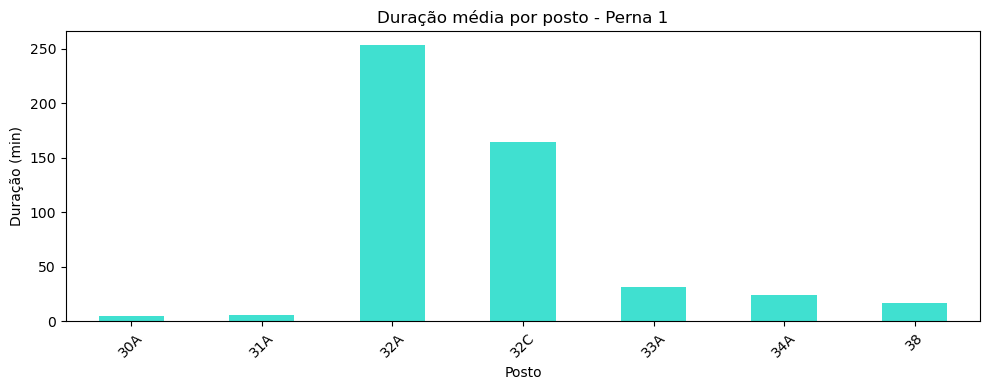

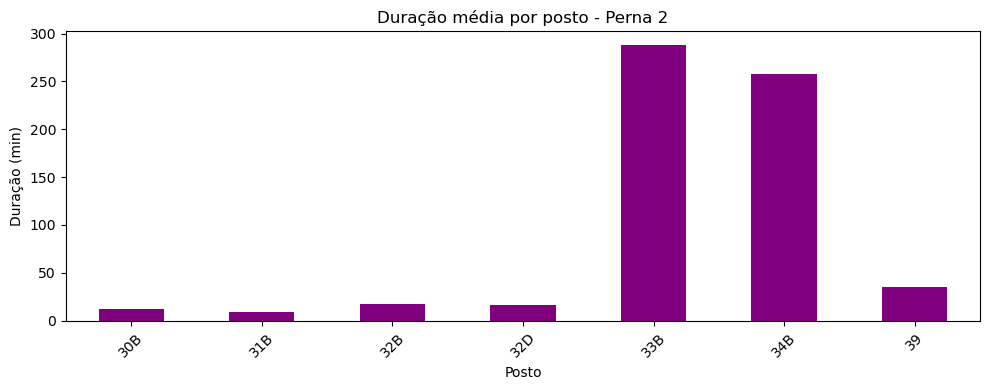

In [108]:
plot_duracao_media_por_posto(df_log)


In [109]:

def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    # 1. Construir a lista de dados com tempos por modelo, atividade e posto
    for modelo, props in MODELOS_CSV.items():
        perna = props["perna"]
        arquivo = props["tempos"]
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2

        tempos_atividade = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        for atividade, dados in atividades_dict.items():
            if modelo not in dados["modelos"]:
                continue

            tempo_total = tempos_atividade.get(atividade, 0)
            tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

            for posto in dados["postos"]:
                lista_dados.append({
                    "modelo": modelo,
                    "atividade": atividade,
                    "posto": posto,
                    "tempo_min": tempo_por_operador / 60,
                    "perna": perna
                })

    df_atividades = pd.DataFrame(lista_dados)

    def ordenar_por_posto(df, ordem_postos):
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 2. Gerar gráfico para cada modelo
    modelos = df_atividades["modelo"].unique()
    for modelo in modelos:
        df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
        perna = df_modelo["perna"].iloc[0]
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        linha_meta = 5.5 if perna == 1 else 16.5

        plt.figure(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
        plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        plt.title(f"Tempo por Atividade - {modelo}")
        plt.xlabel("Atividade")
        plt.ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

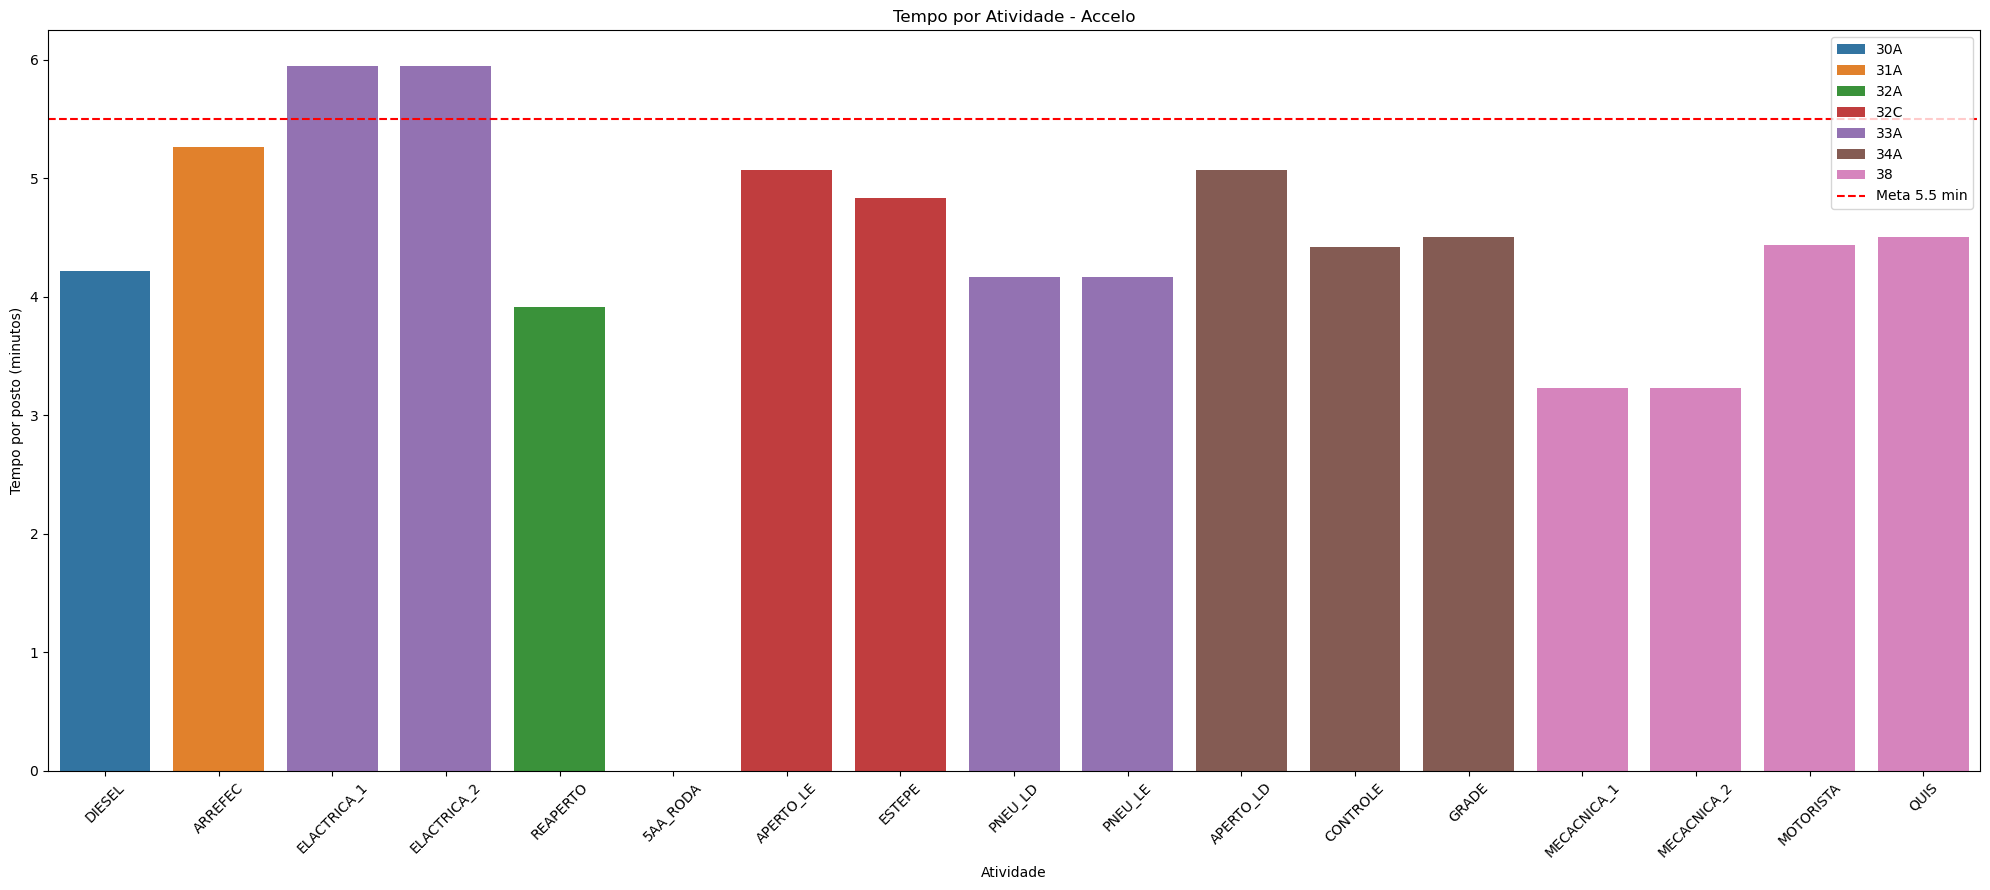

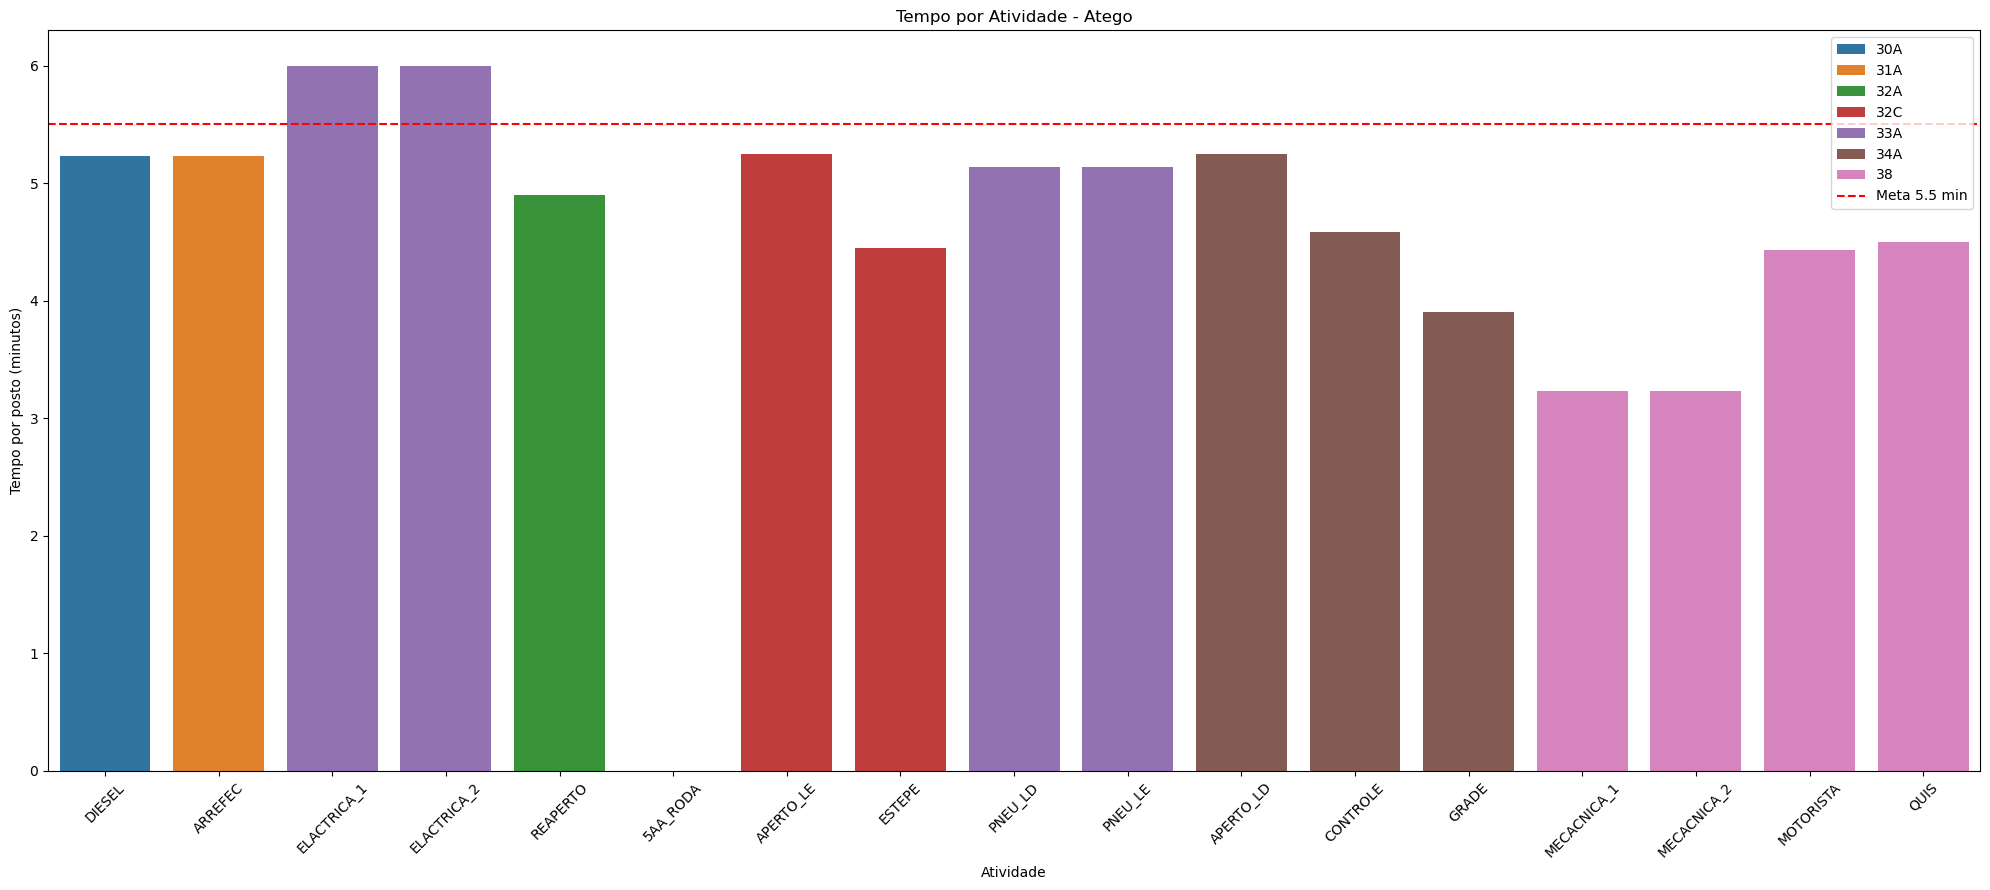

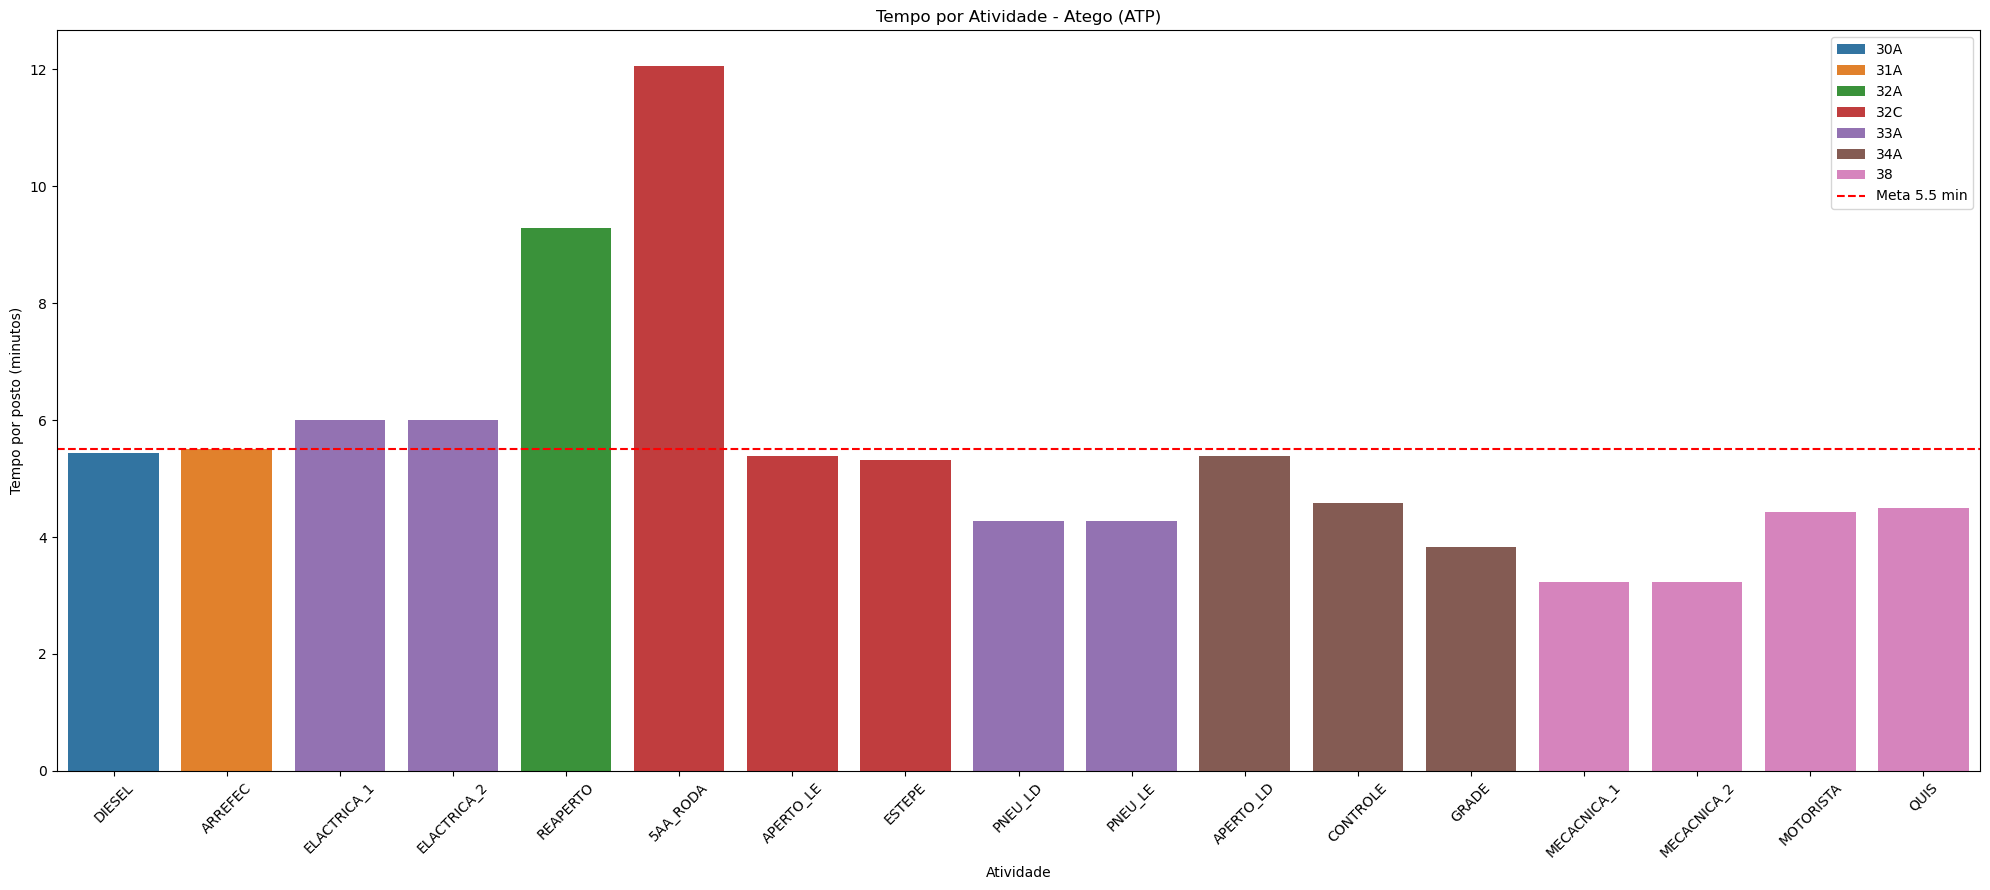

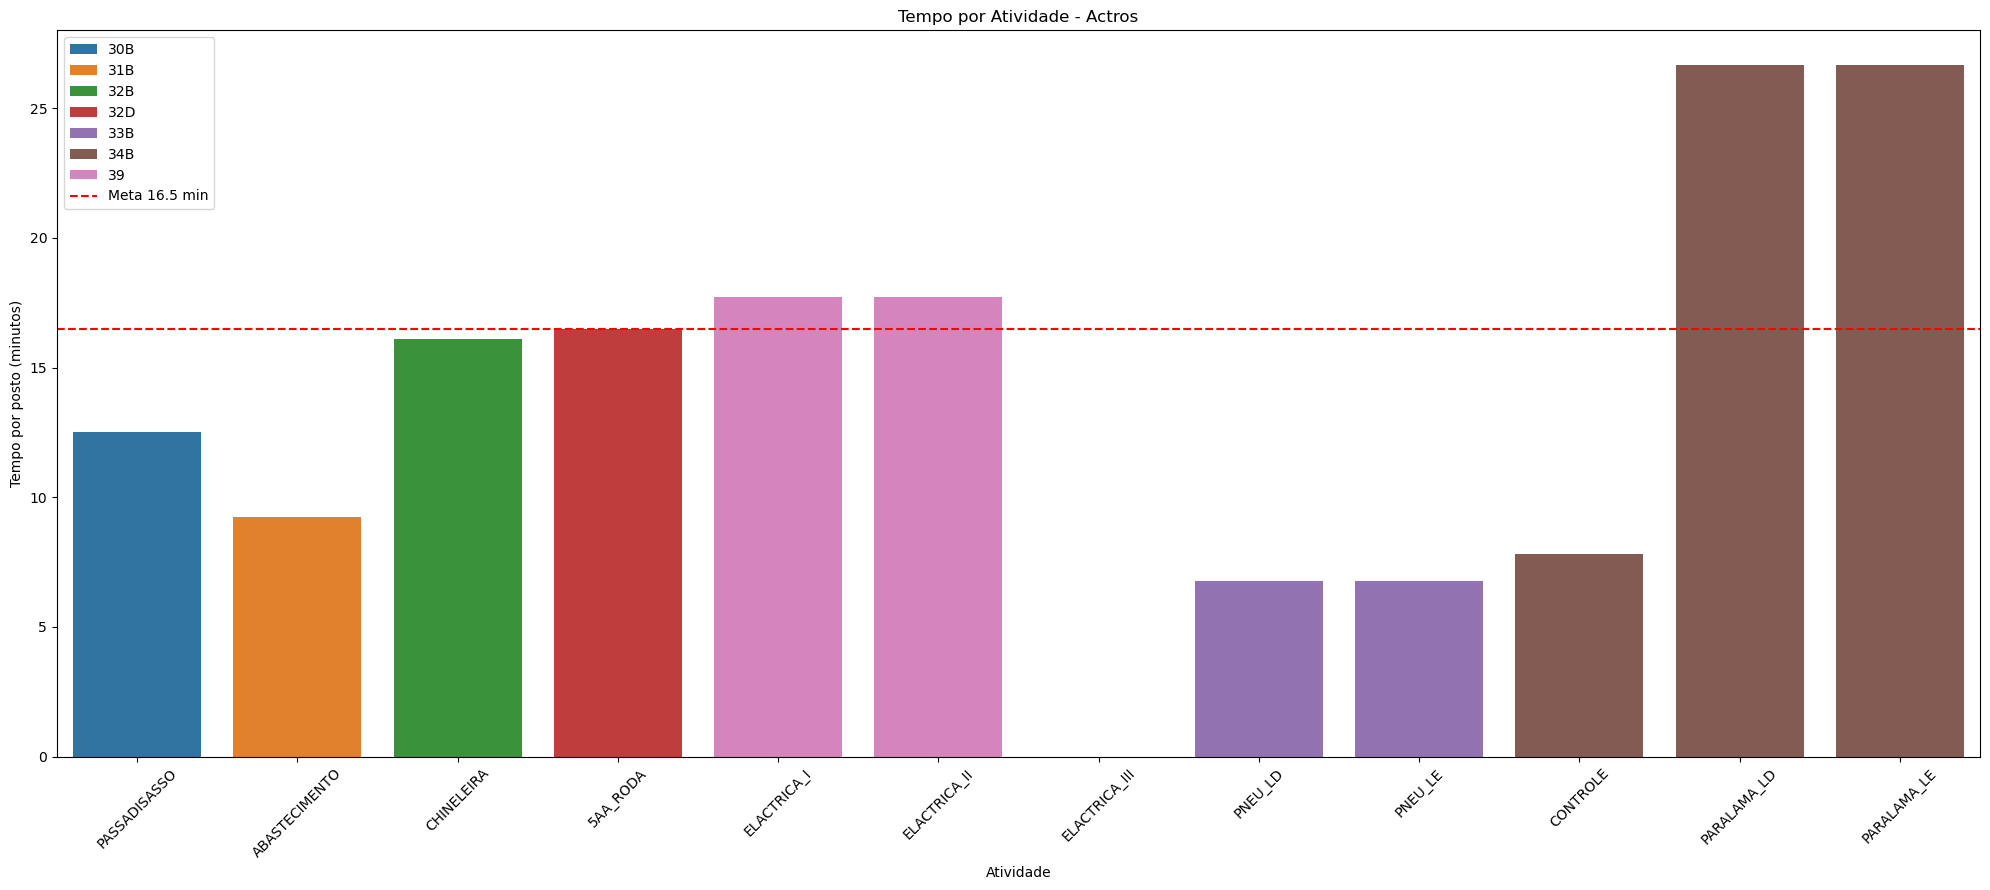

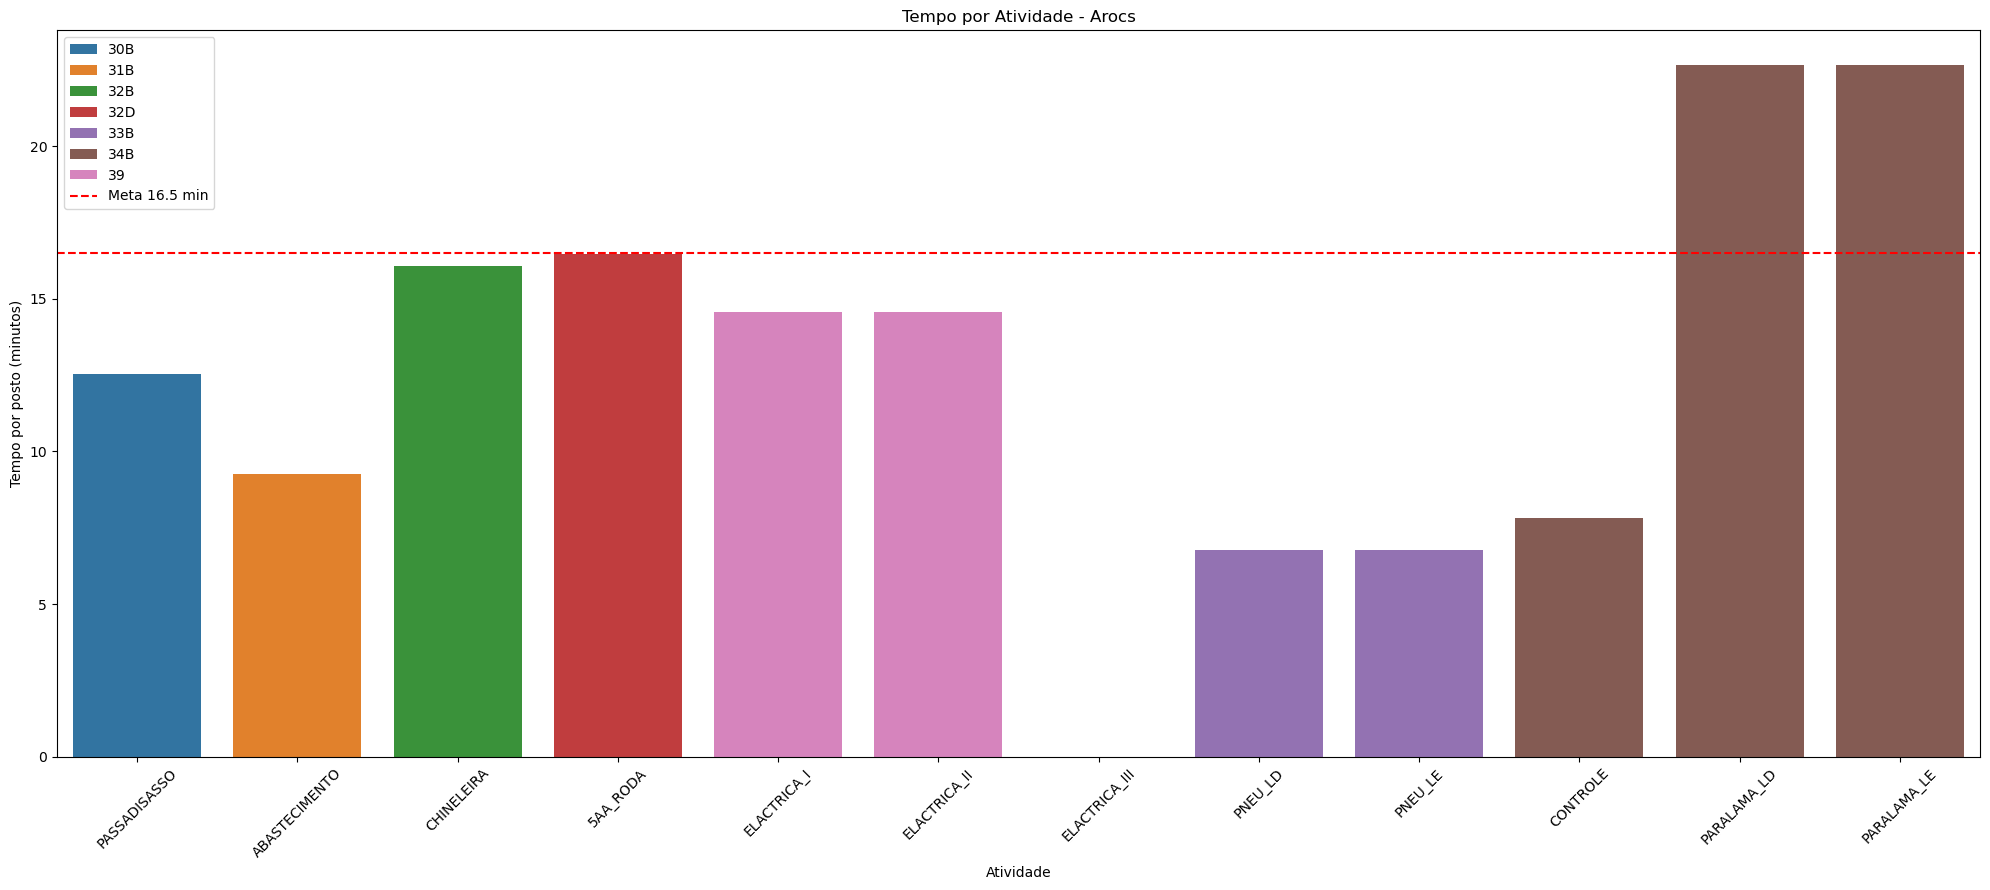

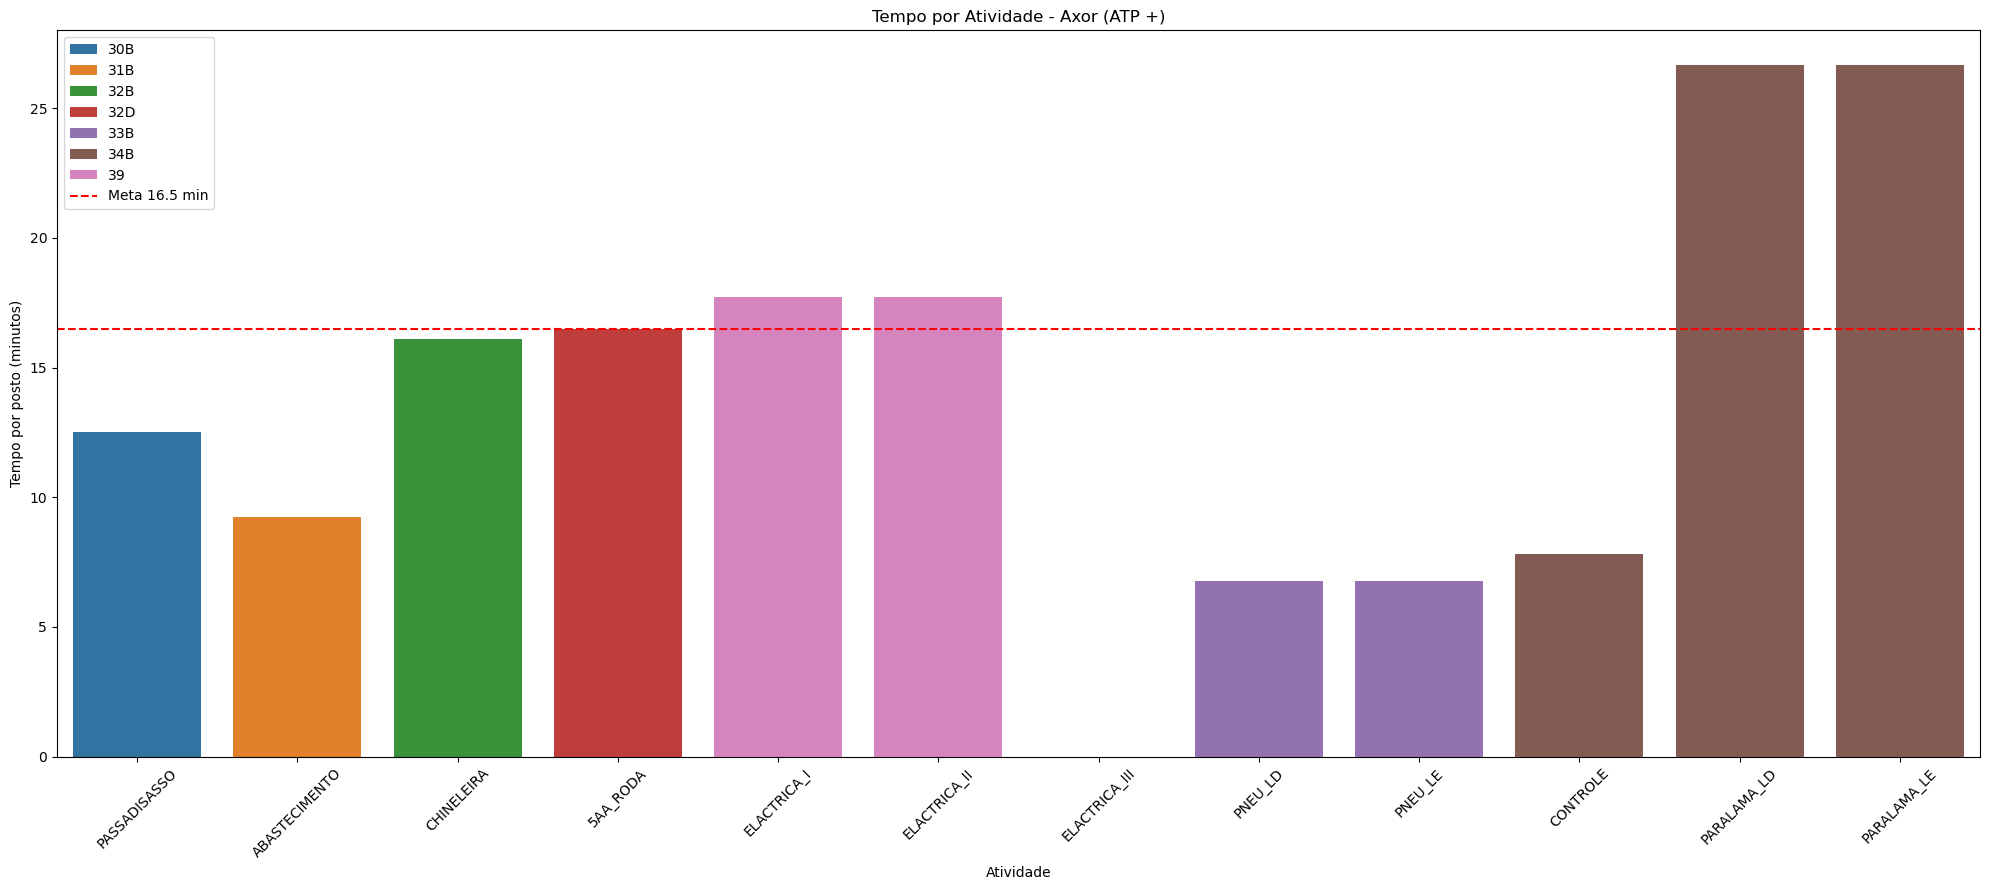

In [110]:
plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)


In [111]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()

    plt.figure(figsize=(6, 4))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [112]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    modelos_produzidos.plot(kind='bar', color='navy')

    for i, valor in enumerate(modelos_produzidos):
        plt.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    plt.title("Modelos Produzidos no Turno")
    plt.xlabel("Modelo")
    plt.ylabel("Quantidade de Veículos")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


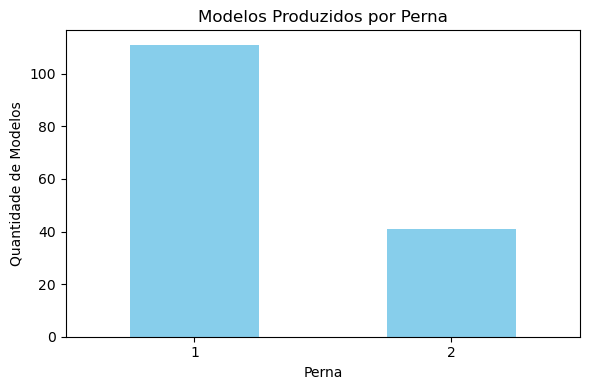

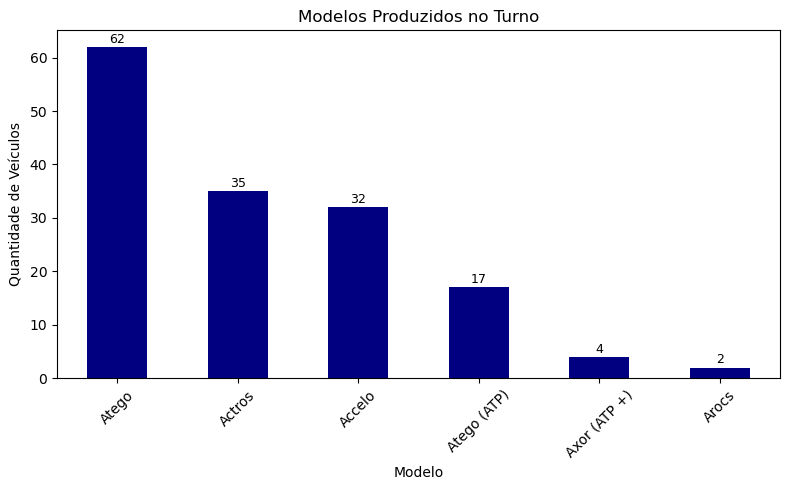

In [113]:
plot_modelos_por_perna(df_log)
plot_modelos_produzidos(df_log)

In [2]:
# NÃO PRECISAMOS DESSE GRÁFICO FICA REDUNDANTE COM O OUTRO
# def plot_eficiencia_postos_heatmap(df_log, TURN_DURATION):
#     """
#     Plota dois heatmaps (por perna) da eficiência de cada posto,
#     definida como a média de tempo de uso dividido pelo tempo total disponível (por turno).

#     Parâmetros:
#     - df_log: DataFrame contendo colunas ['perna', 'posto', 'duracao']
#     - tempo_turno_min: tempo total disponível por posto no turno, em minutos (default=480)
#     """
#     df_posto = df_log.copy()
#     df_posto["duracao_min"] = df_posto["duracao"] / 60

#     # Agrupar por perna e posto
#     eficiencia_posto = df_posto.groupby(["perna", "posto"])["duracao_min"].mean().reset_index()
#     eficiencia_posto["eficiencia"] =(eficiencia_posto["duracao_min"] / TURN_DURATION)*100

#     # Pivotar para heatmap
#     heatmap_p1 = eficiencia_posto[eficiencia_posto["perna"] == 1].pivot(index="posto", columns="perna", values="eficiencia")
#     heatmap_p2 = eficiencia_posto[eficiencia_posto["perna"] == 2].pivot(index="posto", columns="perna", values="eficiencia")

#     # Plot perna 1
#     plt.figure(figsize=(4, 5))
#     sns.heatmap(heatmap_p1, annot=True, fmt=".2%", cmap="YlGnBu", cbar=True)
#     plt.title("Porcentagem de Ocupação por Posto - Perna 1 [%]")
#     plt.ylabel("Posto")
#     plt.xlabel("")
#     plt.tight_layout()
#     plt.show()

#     # Plot perna 2
#     plt.figure(figsize=(4, 5))
#     sns.heatmap(heatmap_p2, annot=True, fmt=".2%", cmap="YlGnBu", cbar=True)
#     plt.title("Porcentagem de Ocupação por Posto - Perna 2 [%]")
#     plt.ylabel("Posto")
#     plt.xlabel("")
#     plt.tight_layout()
#     plt.show()


In [1]:
# plot_eficiencia_postos_heatmap(df_log, TURN_DURATION)


In [ ]:
def plot_eficiencia_por_modelo_heatmap(df_log, TURN_DURATION):
 
    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # Agrupar por modelo, perna e posto
    eficiencia_modelo_posto = df.groupby(["perna", "modelo", "posto"])["duracao_min"].mean().reset_index()
    eficiencia_modelo_posto["eficiencia"] = (eficiencia_modelo_posto["duracao_min"] / TURN_DURATION)*100

    for perna in [1, 2]:
        data = eficiencia_modelo_posto[eficiencia_modelo_posto["perna"] == perna]

        # Obter todos os modelos e todos os postos da perna
        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        # Criar índice completo (todas combinações modelo × posto)
        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        # Reindexar para garantir que todas as combinações estejam presentes
        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        # Criar pivot para o heatmap
        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        # Plotar
        plt.figure(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True)
        plt.title(f"Eficiência por Modelo e Posto - Perna {perna}")
        plt.ylabel("Posto")
        plt.xlabel("Modelo")
        plt.tight_layout()
        plt.show()

#ponderar pelo nº de carros do modelo


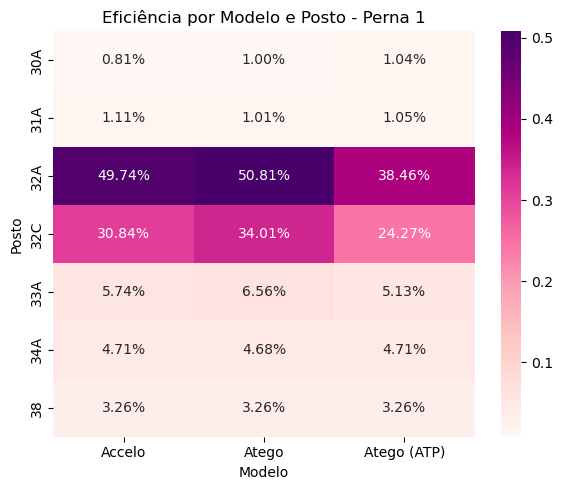

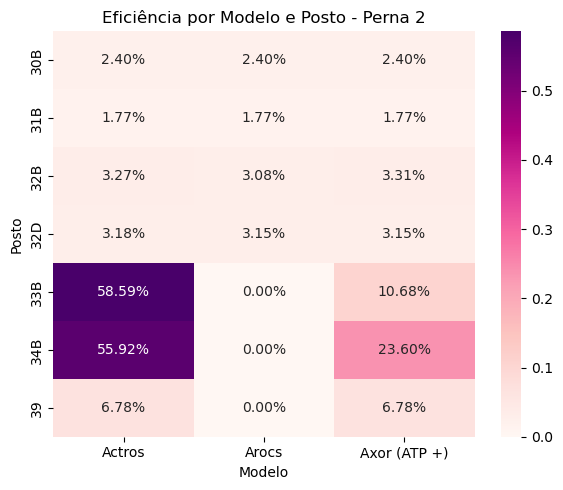

In [117]:
plot_eficiencia_por_modelo_heatmap(df_log, TURN_DURATION)

C:\Users\User\AppData\Local\Temp\ipykernel_24180\1646662938.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


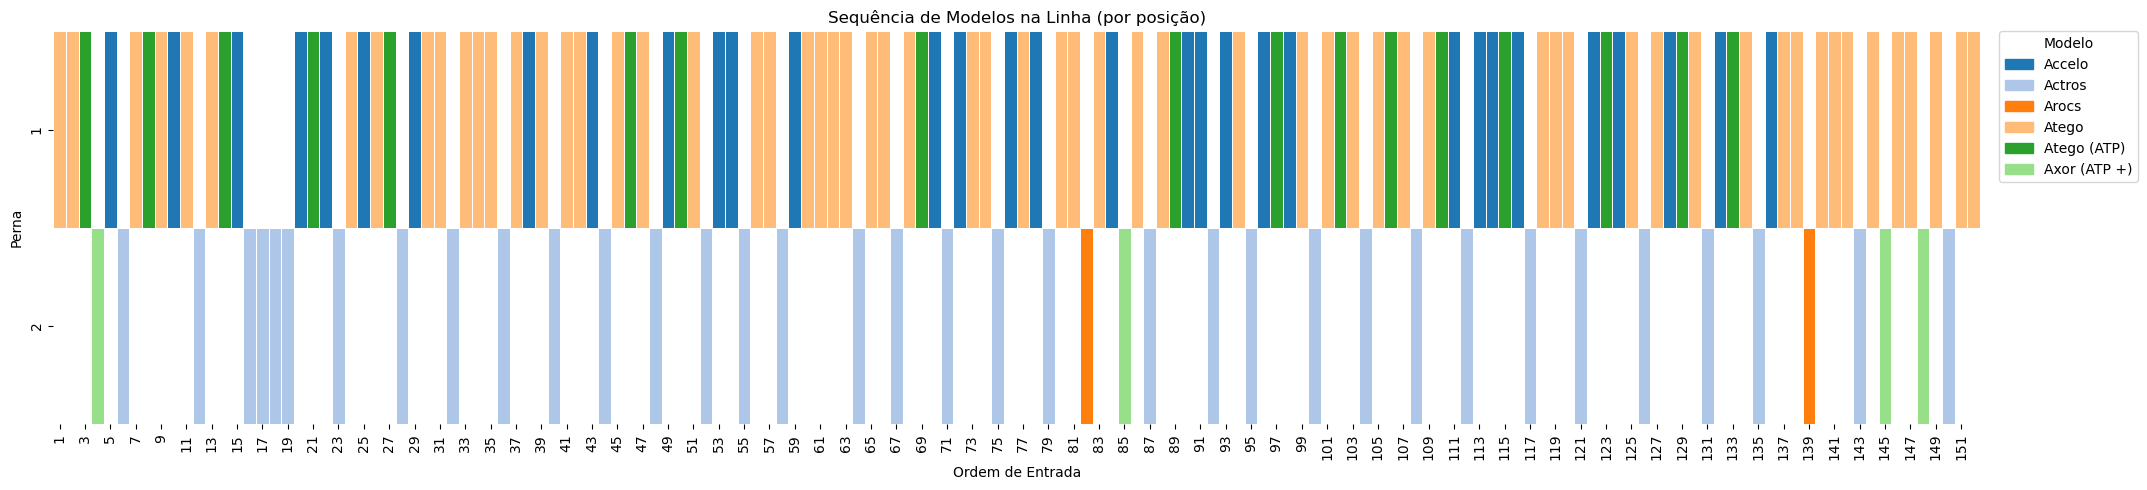

In [118]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}

    # 5. Heatmap
    plt.figure(figsize=(20, 5))
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )

    plt.show()

plot_sequencia_modelos_heatmap(df_log)

In [3]:
# # Tempo total por modelo individual (nome), com identificação do tipo de modelo (ex: Accelo, Atego)
# df_tempo_modelos = df_log.groupby("nome").agg(
#     modelo=("modelo", "first"),
#     tempo_total_min=("duracao", "sum")
# ).reset_index()
# df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

# # Boxplot
# plt.figure(figsize=(10, 5))
# sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3")
# plt.title("Distribuição do Tempo de Produção por Modelo")
# plt.xlabel("Modelo")
# plt.ylabel("Tempo Total de Produção (minutos)")
# plt.xticks(rotation=45)
# plt.show()

In [121]:

# for perna_id in sorted(df_log["perna"].unique()):
#     gantt_data = df_log[df_log["perna"] == perna_id].copy()
#     gantt_data.sort_values("entrada", inplace=True)

#     plt.figure(figsize=(12, 6))
#     for i, row in gantt_data.iterrows():
#         plt.barh(row["posto"], row["duracao"], left=row["entrada"], height=0.6)

#     plt.title(f"Gantt de Ocupação dos Postos – Perna {perna_id}")
#     plt.xlabel("Tempo (s)")
#     plt.ylabel("Posto")
#     plt.tight_layout()
#     plt.show()

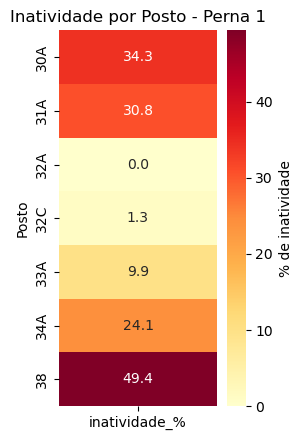

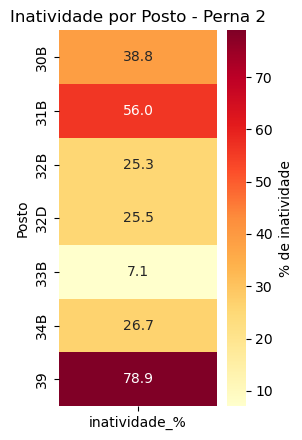

In [128]:

# Certifique-se de que entrada e saída estão em segundos
# tempo total de operação = 8 horas = 480 minutos
tempo_total = 14*60  # minutos

# Função para calcular tempo ocupado real, evitando sobreposição
def calcular_tempo_ocupado_real(intervalos):
    """Recebe lista de (entrada, saída) em segundos e retorna tempo total ocupado sem sobreposição (em minutos)"""
    if not intervalos:
        return 0

    intervalos = sorted(intervalos, key=lambda x: x[0])
    tempo_ocupado = 0

    inicio, fim = intervalos[0]
    for i in range(1, len(intervalos)):
        prox_inicio, prox_fim = intervalos[i]
        if prox_inicio <= fim:
            fim = max(fim, prox_fim)
        else:
            tempo_ocupado += fim - inicio
            inicio, fim = prox_inicio, prox_fim

    tempo_ocupado += fim - inicio
    return tempo_ocupado / 60  # em minutos

# Agrupar os intervalos por (perna, posto)
postos_intervalos = df_log.groupby(["perna", "posto"])[["entrada", "saida"]].apply(lambda x: list(x.itertuples(index=False, name=None)))

# Calcular inatividade
dados_inatividade = []
for (perna, posto), intervalos in postos_intervalos.items():
    tempo_ocupado = calcular_tempo_ocupado_real(intervalos)
    tempo_ocioso = max(0, tempo_total - tempo_ocupado)
    inatividade_pct = round(100 * tempo_ocioso / tempo_total, 2)
    
    dados_inatividade.append({
        "perna": perna,
        "posto": posto,
        "inatividade_%": inatividade_pct
    })

df_inatividade = pd.DataFrame(dados_inatividade)

# Criar heatmaps por perna
for perna in sorted(df_inatividade["perna"].unique()):
    df_p = df_inatividade[df_inatividade["perna"] == perna]
    df_pivot = df_p.pivot_table(index=["posto"], values="inatividade_%", aggfunc="mean")

    plt.figure(figsize=(3, len(df_pivot) * 0.5 + 1))
    sns.heatmap(df_pivot, annot=True, cmap="YlOrRd", fmt=".1f", cbar_kws={"label": "% de inatividade"})
    plt.title(f"Inatividade por Posto - Perna {perna}")
    plt.xlabel("")
    plt.ylabel("Posto")
    plt.tight_layout()
    plt.show()

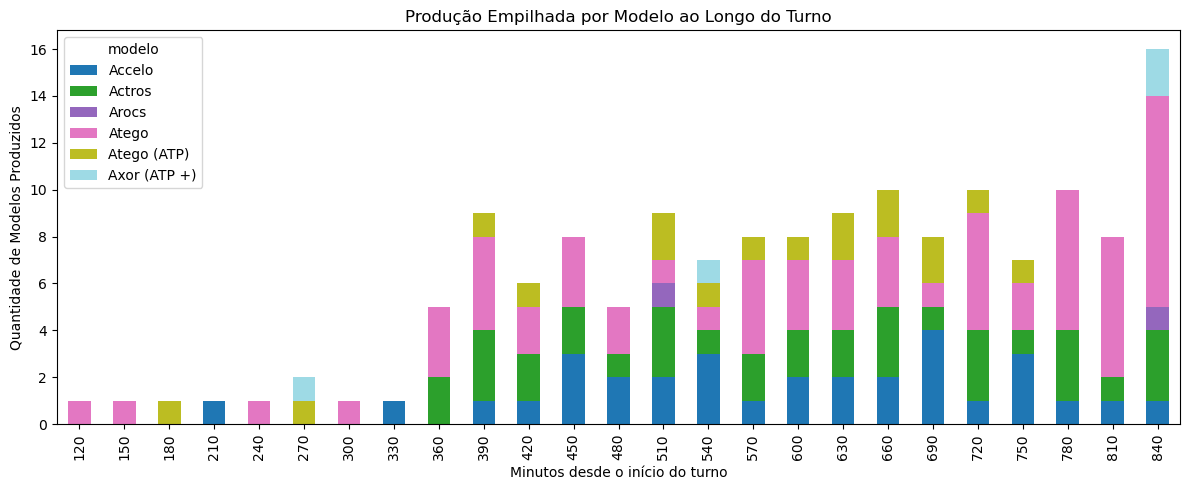

In [125]:

# Calcular o tempo de saída total por modelo (última estação)
modelos_completos = df_log.groupby("nome").agg(
    modelo=("modelo", "first"),
    saida_total=("saida", "max")
).reset_index()

# Criar colunas de slot de tempo de 30 minutos
modelos_completos["slot"] = (modelos_completos["saida_total"] // (30 * 60)).astype(int)

# Agrupar por slot e modelo e contar quantos modelos foram finalizados em cada slot
pivot = modelos_completos.groupby(["slot", "modelo"]).size().unstack(fill_value=0)

# Converter o índice (slot) para minutos desde o início do turno
pivot.index = pivot.index * 30

# Plot do gráfico empilhado
pivot.plot(kind="bar", stacked=True, figsize=(12, 5), colormap="tab20")
plt.xlabel("Minutos desde o início do turno")
plt.ylabel("Quantidade de Modelos Produzidos")
plt.title("Produção Empilhada por Modelo ao Longo do Turno")
plt.tight_layout()
plt.show()
